#**Configuração do Ambiente**

In [1]:
!pip uninstall -y fastai thinc
!pip install numpy==1.26.4 --quiet

Found existing installation: fastai 2.7.19
Uninstalling fastai-2.7.19:
  Successfully uninstalled fastai-2.7.19
Found existing installation: thinc 8.3.6
Uninstalling thinc-8.3.6:
  Successfully uninstalled thinc-8.3.6
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 48.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spacy 3.8.7 requires thinc<8.4.0,>=8.3.4, which is not installed.


##**Imports**

In [1]:
import os
import re
import json
import random
import pandas as pd
from collections import Counter
import torch
from torch.utils.data import Dataset
import kagglehub
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer, AutoTokenizer
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from datasets import Dataset, DatasetDict
from transformers import EarlyStoppingCallback

#**Pré-processamento**

##**Carregar o Dataset**

Primeiro, é realizado o carregamento dos dados e a inicialização das variaveis.

In [2]:
path = kagglehub.dataset_download("victorcallejasf/multimodal-hate-speech")

print("Path to dataset files:", path)

100%|██████████| 5.97G/5.97G [02:31<00:00, 42.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/victorcallejasf/multimodal-hate-speech/versions/1


In [3]:
print(os.listdir(path))

['hatespeech_keywords.txt', 'img_resized', 'MMHS150K_GT.json', 'img_txt', 'splits', 'MMHS150K_readme.txt']


In [4]:
json_gt_path = os.path.join(path, "MMHS150K_GT.json")
splits_paths = {
    "Treino": os.path.join(path, "splits", "train_ids.txt"),
    "Validação": os.path.join(path, "splits", "val_ids.txt"),
    "Teste": os.path.join(path, "splits", "test_ids.txt"),
}

with open(json_gt_path, 'r') as f:
    full_data_json = json.load(f)

##**Analise da distribuição de classes**

Realizamos uma analise inicial da distribuição das classes no dataset. Existem 6 labels no dataset:

* 0: "Não é hate"
* 1: "Racista"
* 2: "Sexista"
* 3: "Homofóbico"
* 4: "Religião"
* 5: "Outro"

Na análise, observamos que a label "Não Hate" possui uma quantidade significativamente maior de ocorrências. As demais categorias, que representam diferentes tipos de discurso de ódio, estão distribuídas entre os tipos, mas de forma desproporcional. Além disso, quando comparadas ao volume de "Não Hate", essas categorias representam uma parcela muito menor do total.



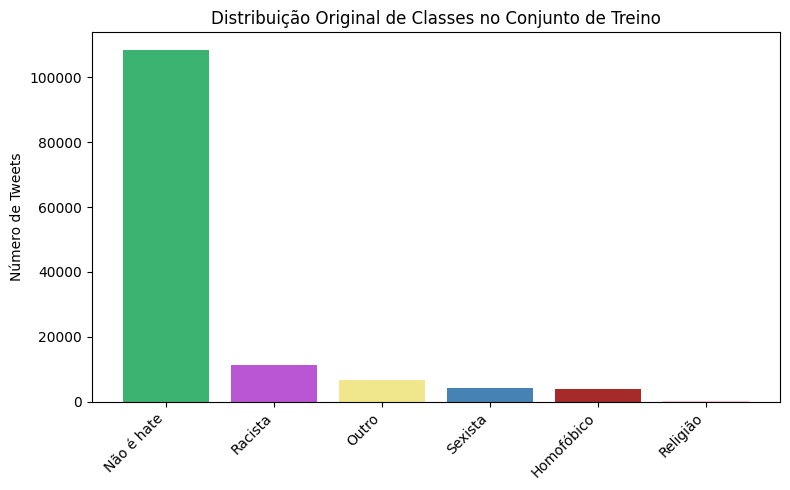

In [5]:
with open(splits_paths['Treino'], 'r') as f:
    train_ids = [line.strip() for line in f.readlines()]

original_train_labels = []
for tweet_id in train_ids:
    if tweet_id in full_data_json:
        label_list = full_data_json[tweet_id]['labels']
        most_common = Counter(label_list).most_common(1)[0][0]
        original_train_labels.append(most_common)

labels_map_multiclass = {
    0: "Não é hate", 1: "Racista", 2: "Sexista",
    3: "Homofóbico", 4: "Religião", 5: "Outro"
}

original_label_counts = Counter(original_train_labels)
df_dist_multi = pd.DataFrame({
    'Classe': [labels_map_multiclass[label] for label, count in original_label_counts.items()],
    'Quantidade': [count for label, count in original_label_counts.items()]
}).sort_values(by='Quantidade', ascending=False)

# Plotando o gráfico
plt.figure(figsize=(8, 5))
plt.bar(df_dist_multi['Classe'], df_dist_multi['Quantidade'], color=['mediumseagreen', 'mediumorchid', 'khaki', 'steelblue', 'brown', 'pink'])
plt.title('Distribuição Original de Classes no Conjunto de Treino')
plt.ylabel('Número de Tweets')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

##**Transformação do Dados**

Foi realizada uma limpeza nos dados, removendo URLs, menções (@) e hashtags (#) dos textos. Em seguida, os textos limpos passaram pelo processo de tokenização, a fim de prepará-los no formato compatível com o modelo BERTweet.

In [6]:
def clean_text(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text.lower()

def process_and_binarize_example(example):
    example['text'] = clean_text(example['text'])
    majority_vote = Counter(example['labels_multi']).most_common(1)[0][0]
    example['label'] = 0 if majority_vote == 0 else 1

    return example

model_checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=False)

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [7]:
all_data_list = [{'tweet_id': k, 'text': v['tweet_text'], 'labels_multi': v['labels']} for k, v in full_data_json.items()]
full_dataset = Dataset.from_list(all_data_list)

split_ids_set = {k.lower(): set(open(v, 'r').read().splitlines()) for k, v in splits_paths.items()}
raw_datasets = DatasetDict({
    'train': full_dataset.filter(lambda x: x['tweet_id'] in split_ids_set['treino']),
    'validation': full_dataset.filter(lambda x: x['tweet_id'] in split_ids_set['validação']),
    'test': full_dataset.filter(lambda x: x['tweet_id'] in split_ids_set['teste'])
})

processed_datasets = raw_datasets.map(process_and_binarize_example, remove_columns=['labels_multi', 'tweet_id'])

Filter:   0%|          | 0/149823 [00:00<?, ? examples/s]

Filter:   0%|          | 0/149823 [00:00<?, ? examples/s]

Filter:   0%|          | 0/149823 [00:00<?, ? examples/s]

Map:   0%|          | 0/134823 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [8]:
tokenized_datasets = processed_datasets.map(tokenize_function, batched=True, remove_columns=['text'])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

train_dataset = tokenized_datasets["train"]
val_dataset = tokenized_datasets["validation"]
test_dataset = tokenized_datasets["test"]

print(tokenized_datasets)

Map:   0%|          | 0/134823 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 134823
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10000
    })
})


##**Binarização das Labels**

Como observado anteriormente, as labels estão bastante desbalanceadas. Por esse motivo, optamos por binarizar as classes, ou seja, reduzir para apenas duas categorias: 1 (Não Hate) e 0 (Hate). Para isso, agrupamos todas as categorias originalmente rotuladas de 1 a 5 sob a label Hate (0).

In [9]:
train_labels_binary = processed_datasets['train']['label']
binary_labels_map = {0: "Não Hate", 1: "Hate"}
binary_label_counts = Counter(train_labels_binary)

df_binary_dist = pd.DataFrame({
    'Classe': [binary_labels_map[label] for label in binary_label_counts.keys()],
    'Quantidade': list(binary_label_counts.values())
})

print("Distribuição das Classes Após Binarização:")
print(df_binary_dist)
print(f"\nProporção 'Não Hate': {binary_label_counts[0] / len(train_labels_binary):.2%}")
print(f"Proporção 'Hate':     {binary_label_counts[1] / len(train_labels_binary):.2%}")

Distribuição das Classes Após Binarização:
     Classe  Quantidade
0      Hate       26361
1  Não Hate      108462

Proporção 'Não Hate': 80.45%
Proporção 'Hate':     19.55%


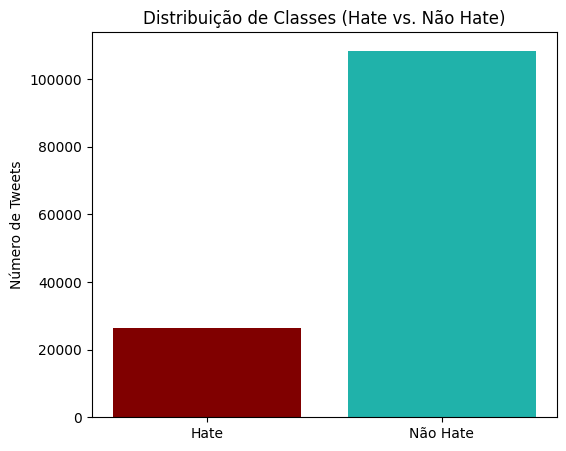

In [10]:
plt.figure(figsize=(6, 5))
plt.bar(df_binary_dist['Classe'], df_binary_dist['Quantidade'], color=['maroon', 'lightseagreen'])
plt.title('Distribuição de Classes (Hate vs. Não Hate)')
plt.ylabel('Número de Tweets')
plt.show()

##**Tratamento do Desbalanceamento das Classes**

Mesmo após a binarização das labels, as classes continuaram desbalanceadas. Por isso, foi aplicado um undersampling na classe majoritária, a fim de equilibrar a distribuição entre as classes.

In [11]:
df_train = processed_datasets['train'].to_pandas()

df_hate = df_train[df_train['label'] == 1]
df_not_hate = df_train[df_train['label'] == 0]

n_hate_samples = len(df_hate)
df_not_hate_undersampled = df_not_hate.sample(n=n_hate_samples, random_state=42)

df_train_balanced = pd.concat([df_hate, df_not_hate_undersampled]).sample(frac=1, random_state=42).reset_index(drop=True)

print("Distribuição das Classes no Treino Após Undersampling:")
print(df_train_balanced['label'].value_counts())

balanced_train_dataset = Dataset.from_pandas(df_train_balanced)

Distribuição das Classes no Treino Após Undersampling:
label
1    26361
0    26361
Name: count, dtype: int64


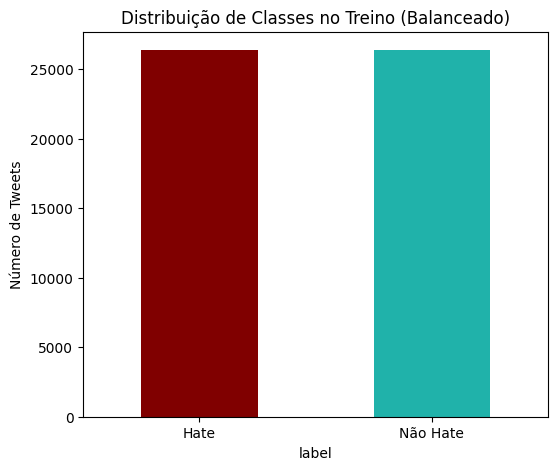

In [12]:
plt.figure(figsize=(6, 5))
df_train_balanced['label'].value_counts().plot(kind='bar', color=['maroon', 'lightseagreen'])
plt.title('Distribuição de Classes no Treino (Balanceado)')
plt.xticks(ticks=[0, 1], labels=['Hate', 'Não Hate'], rotation=0)
plt.ylabel('Número de Tweets')
plt.show()

In [13]:
tokenized_balanced_train_dataset = balanced_train_dataset.map(tokenize_function, batched=True, remove_columns=['text'])
tokenized_balanced_train_dataset = tokenized_balanced_train_dataset.rename_column("label", "labels")
tokenized_balanced_train_dataset.set_format("torch")

Map:   0%|          | 0/52722 [00:00<?, ? examples/s]

#**Treinamento do Modelo**

O treinamento do modelo foi realizado utilizando a classe Trainer da biblioteca Hugging Face. Como a tarefa consiste em classificação binária (Hate ou Não Hate), foi definida uma função de métricas personalizada para calcular accuracy, f1-score, precision e recall, sendo o f1-score utilizado como principal métrica de desempenho, devido ao seu balancamente de precisão e recall.

Foram utilizados os seguintes parâmetros de configuração:

* Épocas: 10
* Taxa de aprendizado: 2e-5
* Batch size (treinamento): 32
* Batch size (validação): 64

A avaliação e o salvamento do modelo ocorrem ao final de cada época. Foi incluído também o uso de EarlyStopping, com paciência de 2 épocas sem melhoria, para evitar overfitting.

In [14]:
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=2)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
def compute_binary_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    f1 = f1_score(labels, preds, average='binary')
    precision = precision_score(labels, preds, average='binary')
    recall = recall_score(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)

    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=8,
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none",
    warmup_steps=100,
    lr_scheduler_type="linear"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_balanced_train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_binary_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.616900,0.608792,0.685800,0.611811,0.687014,0.551448
2,0.596700,0.614371,0.678600,0.646580,0.638575,0.654788
3,0.560300,0.656460,0.676200,0.641100,0.638129,0.644098
4,0.483400,0.741067,0.663600,0.606273,0.638875,0.576837


TrainOutput(global_step=6592, training_loss=0.5682365379287201, metrics={'train_runtime': 4397.5057, 'train_samples_per_second': 95.913, 'train_steps_per_second': 2.998, 'total_flos': 1.387174106068992e+16, 'train_loss': 0.5682365379287201, 'epoch': 4.0})

#**Resultados**

Para avaliar o desempenho do modelo, foi utilizada a partição de teste, que não havia sido vista durante o treinamento. As métricas calculadas foram: acurácia, precisão, recall e f1-score. Em seguida, foi gerada a matriz de confusão, que ajuda a visualizar como o modelo está classificando corretamente ou incorretamente cada classe (Hate e Não Hate).

Por fim, foi plotado um gráfico da loss por época, tanto para o conjunto de treinamento quanto de validação, com o objetivo de verificar se o modelo apresenta sinais de overfitting.

In [16]:
results = trainer.evaluate(test_dataset)
print(results)

{'eval_loss': 0.6249640583992004, 'eval_accuracy': 0.6666, 'eval_f1': 0.6341891595347816, 'eval_precision': 0.6165991039044165, 'eval_recall': 0.6528122882313079, 'eval_runtime': 68.2485, 'eval_samples_per_second': 146.523, 'eval_steps_per_second': 2.3, 'epoch': 4.0}


In [17]:
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids


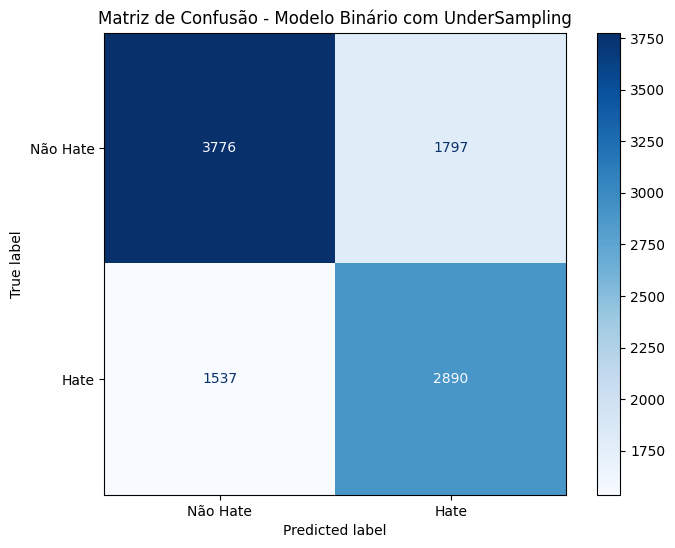

In [18]:
cm = confusion_matrix(labels, preds, labels=list(binary_labels_map.keys()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(binary_labels_map.values()))

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap="Blues", values_format='d', ax=ax)
plt.title("Matriz de Confusão - Modelo Binário com UnderSampling")
plt.grid(False)
plt.show()


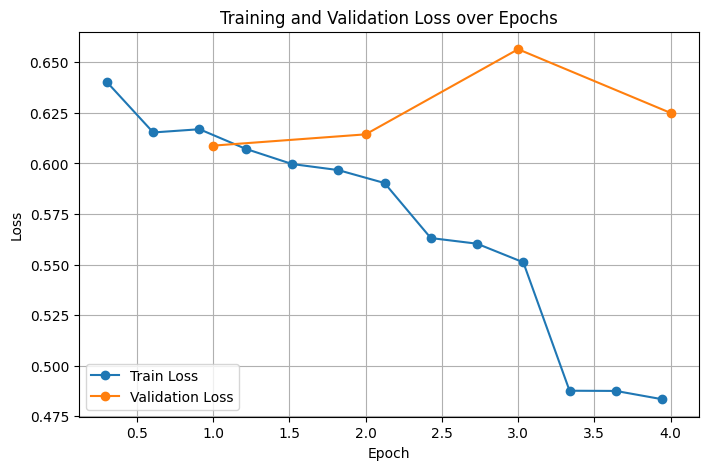

In [19]:
import matplotlib.pyplot as plt
import numpy as np

log_history = trainer.state.log_history

# Coletar dados do treino (mantido igual)
epochs, train_loss = [], []
for log in log_history:
    if 'loss' in log and 'epoch' in log:
        train_loss.append(log['loss'])
        epochs.append(log['epoch'])

# Corrigir os tamanhos do treino
train_epochs = epochs[:len(train_loss)]

# Coletar dados de validação e agrupar por época arredondada
eval_logs = [(round(log['epoch']), log['eval_loss']) for log in log_history if 'eval_loss' in log and 'epoch' in log]

# Remover duplicatas (último valor de cada época)
eval_dict = {}
for epoch, loss in eval_logs:
    eval_dict[epoch] = loss  # sobrescreve mantendo só o último da época

# Ordenar por época
eval_epochs = sorted(eval_dict.keys())
eval_loss = [eval_dict[ep] for ep in eval_epochs]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(train_epochs, train_loss, label="Train Loss", marker='o')
plt.plot(eval_epochs, eval_loss, label="Validation Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()


## **Conclusão**

O modelo de rede neural treinado para a detecção de discurso de ódio apresentou desempenho razoável, com uma acurácia de 0,66 e um F1-score de 0,63, indicando um equilíbrio moderado entre precisão e revocação. No entanto, ao analisar a matriz de confusão, percebe-se uma certa tendência à confusão entre as classes: o modelo identificou corretamente 2.890 instâncias de discurso de ódio, mas também classificou erroneamente 1.797 textos não ofensivos como ofensivos.

Além disso, o gráfico de loss sugere uma possível tendência ao overfitting, com a perda de validação começando a subir enquanto a de treino continua caindo. No entanto, não é possível afirmar com certeza que o modelo sofreria overfitting severo, já que o treinamento foi interrompido antecipadamente por meio do EarlyStoppingCallback(patience=2). Também houve limitações de software e recursos computacionais, que impediram a execução de mais épocas, restringindo a análise completa do comportamento do modelo ao longo de um treinamento mais extenso.